# Music Genre Classification with EfficientNet

This notebook implements a hierarchical music genre classification system using a pre-trained EfficientNet-B0 model. The architecture processes multi-modal spectrograms (mel, CQT, and chroma) and classifies music into three levels of genre categories, leveraging transfer learning from ImageNet pre-training.

## Device Setup

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Package Installation

In [3]:
!pip install torchmetrics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 50.4 MB/s eta 0:00:00


## Import Required Libraries

In [4]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import random
import numpy as np
from PIL import Image
import io
import time, os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

import torchvision.models as models
from torchmetrics.classification import MulticlassAccuracy
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay

## Label Mappings

In [5]:
first_level_labels_map = {
    0: "Classic",
    1: "Non_classic"
}
second_level_labels_map = {
    0: "Symphony",
    1: "Opera",
    2: "Solo",
    3: "Chamber",
    4: "Pop",
    5: "Dance_and_house",
    6: "Indie",
    7: "Soul_or_RnB",
    8: "Rock"
}
third_level_labels_map = {
    0: "Symphony",
    1: "Opera",
    2: "Solo",
    3: "Chamber",
    4: "Pop_vocal_ballad",
    5: "Adult_contemporary",
    6: "Teen_pop",
    7: "Contemporary_dance_pop",
    8: "Dance_pop",
    9: "Classic_indie_pop",
    10: "Chamber_cabaret_and_art_pop",
    11: "Soul_or_RnB",
    12: "Adult_alternative_rock",
    13: "Uplifting_anthemic_rock",
    14: "Soft_rock",
    15: "Acoustic_pop"
}

## Dataset Loading

In [6]:
# Load the dataset
ds = load_dataset("ccmusic-database/music_genre")

# Check the available splits and columns
print(ds)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

eval/train/data-00000-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00001-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00002-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00003-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00004-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00005-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00006-of-00008.arrow:   0%|          | 0.00/458M [00:00<?, ?B/s]

eval/train/data-00007-of-00008.arrow:   0%|          | 0.00/459M [00:00<?, ?B/s]

eval/validation/data-00000-of-00001.arro(…):   0%|          | 0.00/459M [00:00<?, ?B/s]

eval/test/data-00000-of-00001.arrow:   0%|          | 0.00/459M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29100 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3637 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3638 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 29100
    })
    validation: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 3637
    })
    test: Dataset({
        features: ['mel', 'cqt', 'chroma', 'fst_level_label', 'sec_level_label', 'thr_level_label'],
        num_rows: 3638
    })
})


## Data Preprocessing

In [7]:
# Convert each split to pandas (images will remain as PIL.Image objects)

df_train = ds["train"].to_pandas()
df_val = ds["validation"].to_pandas()
df_test = ds["test"].to_pandas()

print("Train shape:", df_train.shape)
print("Validation shape:", df_val.shape)
print("Test shape:", df_test.shape)

df_train.head()

Train shape: (29100, 6)
Validation shape: (3637, 6)
Test shape: (3638, 6)


,mel,cqt,chroma,fst_level_label,sec_level_label,thr_level_label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,8,12
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,8,14
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,1,4,6


## Datatypes

In [8]:
print(df_train.dtypes)

mel                object
cqt                object
chroma             object
fst_level_label     int64
sec_level_label     int64
thr_level_label     int64
dtype: object


## Spectrogram Visualization

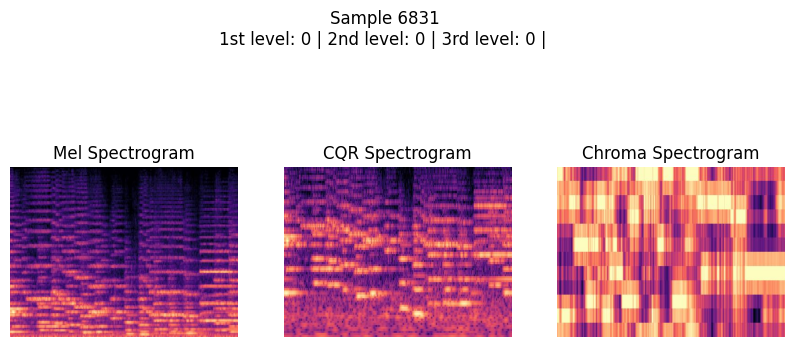

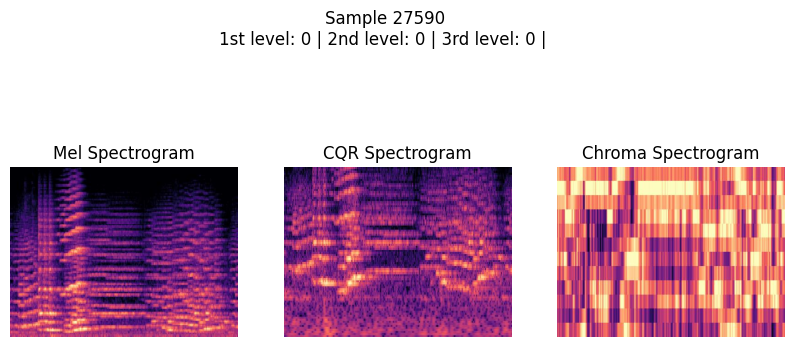

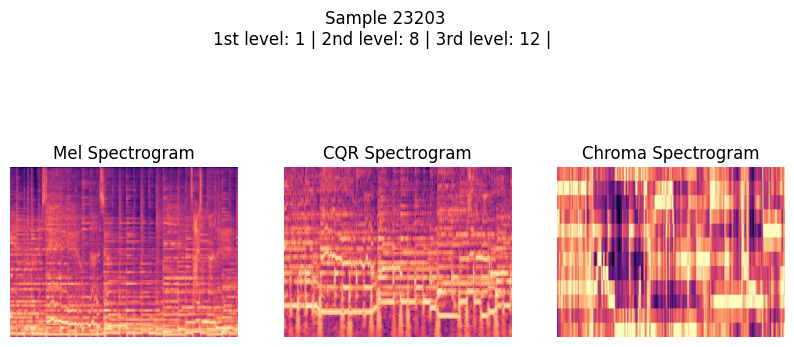

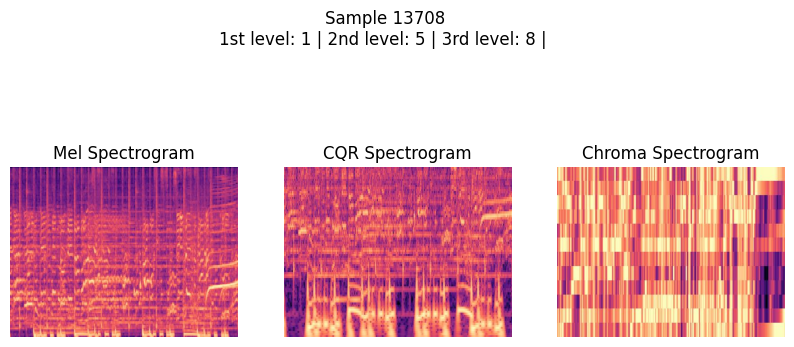

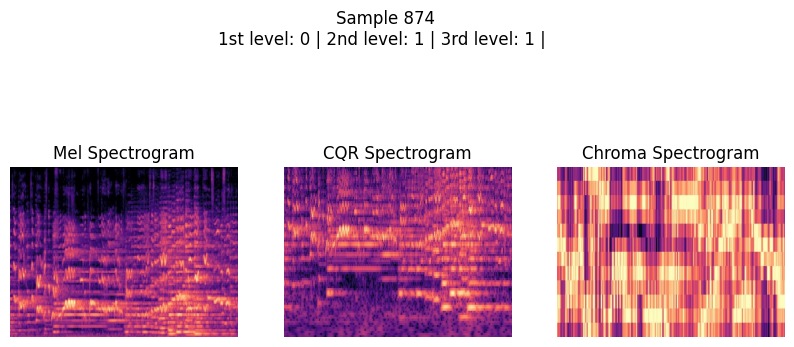

In [9]:
# Pick a few random indices
indices = random.sample(range(len(df_train)), 5)

for i in indices:
  row = df_train.iloc[i]

  # decode from bytes to PIL image
  mel_img = Image.open(io.BytesIO(row["mel"]["bytes"]))
  cqt_img = Image.open(io.BytesIO(row["cqt"]["bytes"]))
  chroma_img = Image.open(io.BytesIO(row["chroma"]["bytes"]))

  # create figure and axes
  fig, axes = plt.subplots(1, 3, figsize=(10, 5))

  # plot mel spectrogram
  axes[0].imshow(mel_img)
  axes[0].set_title("Mel Spectrogram")
  axes[0].axis("off")

  # plot cqt spectrogram
  axes[1].imshow(cqt_img)
  axes[1].set_title("CQR Spectrogram")
  axes[1].axis("off")

  # plot chroma spectrogram
  axes[2].imshow(chroma_img)
  axes[2].set_title("Chroma Spectrogram")
  axes[2].axis("off")

  plt.suptitle(
      f"Sample {i}\n"
      f"1st level: {row['fst_level_label']} | "
      f"2nd level: {row['sec_level_label']} | "
      f"3rd level: {row['thr_level_label']} | "
  )
  plt.show()


## Label Distribution Analysis

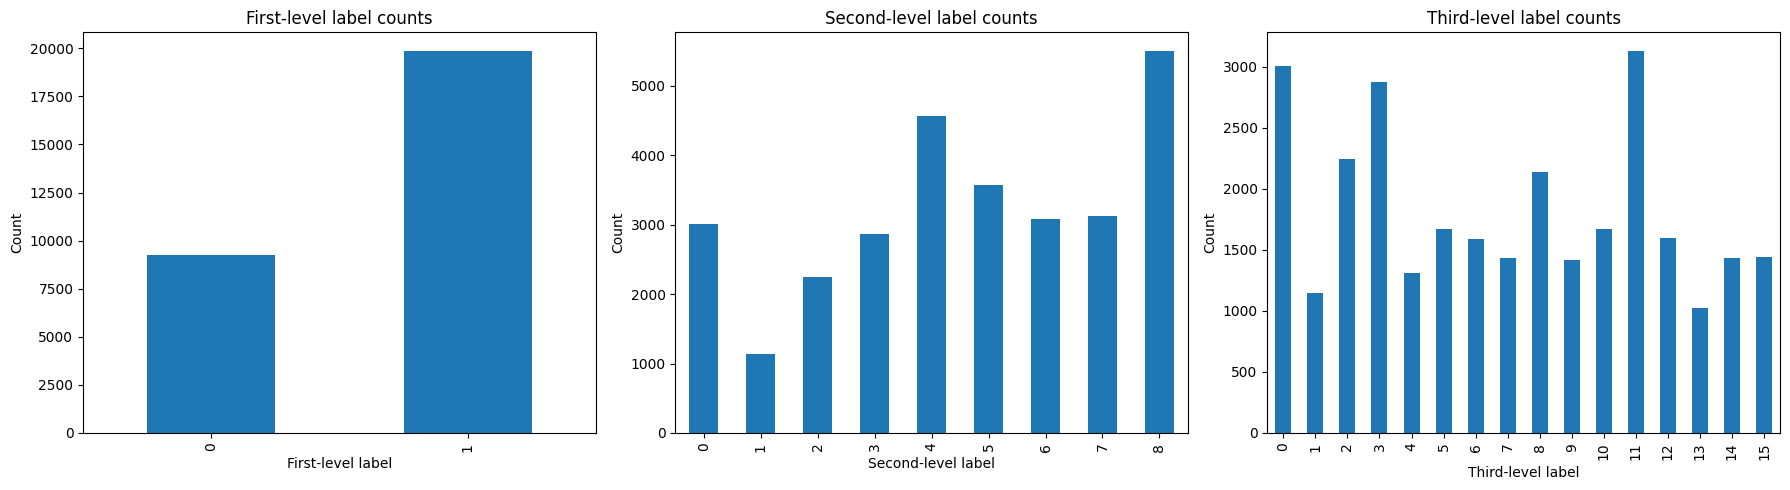

In [10]:
# get label columns from df_train
fst_labels = df_train["fst_level_label"]
sec_labels = df_train["sec_level_label"]
thr_labels = df_train["thr_level_label"]

# plot histograms side by side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

fst_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[0], title="First-level label counts"
)
sec_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[1], title="Second-level label counts"
)
thr_labels.value_counts().sort_index().plot(
    kind="bar", ax=axes[2], title="Third-level label counts"
)

axes[0].set_xlabel("First-level label")
axes[0].set_ylabel("Count")
axes[1].set_xlabel("Second-level label")
axes[1].set_ylabel("Count")
axes[2].set_xlabel("Third-level label")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

## Custom Dataset Implementation

In [11]:
# Dataset class (mel=cqt+chroma -> 3-channel tensor)

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

class MusicGenreDataset(Dataset):
  def __init__(self, df, img_size=(224, 224), normalize_imagenet=True):
    self.df = df.reset_index(drop=True)
    self.tf = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
    ])
    self.norm = transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) if normalize_imagenet else None

  def __len__(self):
    return len(self.df)

  def _decode_gray(self, blob):
    return self.tf(Image.open(io.BytesIO(blob)).convert("L"))

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    # decode 3 grayscale spectrograms
    mel_img = self._decode_gray(row["mel"]["bytes"])
    cqt_img = self._decode_gray(row["cqt"]["bytes"])
    chroma_img = self._decode_gray(row["chroma"]["bytes"])

    # stack into [3,224,224]
    x = torch.cat([mel_img, cqt_img, chroma_img], dim=0)

    if self.norm:
      x = self.norm(x)

    fst = int(row["fst_level_label"])
    sec = int(row["sec_level_label"])
    thr = int(row["thr_level_label"])

    return x, fst, sec, thr


## Data Loader Setup

In [17]:
# Datasets
train_dataset = MusicGenreDataset(df_train, img_size=(224,224), normalize_imagenet=True)
val_dataset = MusicGenreDataset(df_val, img_size=(224,224), normalize_imagenet=True)
test_dataset = MusicGenreDataset(df_test, img_size=(224,224), normalize_imagenet=True)

BATCH_SIZE = 64
NUM_WORKERS = 8

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# Sanity Checks
xb, y1b, y2b, y3b = next(iter(train_loader))
print("Batch shapes:", xb.shape, y1b.shape, y2b.shape, y3b.shape)  # expect [B, 1, 224, 224], [B], [B], [B]

Batch shapes: torch.Size([64, 3, 224, 224]) torch.Size([64]) torch.Size([64]) torch.Size([64])


## EfficientNet Model Architecture

In [19]:
# AST Model Definition (3 heads)
class EffNetMultiHead(nn.Module):
  def __init__(
      self,
      num_fst,
      num_sec,
      num_thr,
      dropout=0.3,
      pretrained=True,
      freeze_backbone=False,
  ):
    super().__init__()

    # Load EfficientNet-B0 backbone
    if pretrained:
      self.backbone = models.efficientnet_b0(weights="IMAGENET1K_V1")
    else:
      self.backbone = models.efficientnet_b0(weights=None)

    feat_dim = self.backbone.classifier[1].in_features

    # Replace classifier with identity
    self.backbone.classifier = nn.Identity()

    # Freeze backbone parameters
    if freeze_backbone:
      for param in self.backbone.parameters():
        param.requires_grad = False

    self.dropout = nn.Dropout(dropout)

    # Three heads
    self.head_fst = nn.Linear(feat_dim, num_fst)
    self.head_sec = nn.Linear(feat_dim, num_sec)
    self.head_thr = nn.Linear(feat_dim, num_thr)

  def forward(self, x):
    f = self.backbone(x) # [B, 1280]
    f = self.dropout(f)

    return self.head_fst(f), self.head_sec(f), self.head_thr(f)

num_fst = df_train["fst_level_label"].nunique()
num_sec = df_train["sec_level_label"].nunique()
num_thr = df_train["thr_level_label"].nunique()

model = EffNetMultiHead(
    num_fst=num_fst,
    num_sec=num_sec,
    num_thr=num_thr,
    dropout=0.3,
    pretrained=True,
    freeze_backbone=False,
).to(device)

print("Model ready. Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

Model ready. Trainable params: 4042135


## Training Configuration

In [20]:
# Loss Functions (with label smoothing)

# Loss functions
criterions = {
    "fst": nn.CrossEntropyLoss(label_smoothing=0.1),
    "sec": nn.CrossEntropyLoss(label_smoothing=0.1),
    "thr": nn.CrossEntropyLoss(label_smoothing=0.1)
}

# Optimizer & Scheduler
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=30
)

# AMP scaler (for mixed precision)
scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

## Training and Validation Functions

In [21]:
# Training and Validation Loops

def train_epoch(model, loader, criterions, optimizer, device):
  model.train()
  total_loss = 0.0
  all_fst_preds, all_fst_trues = [], []
  all_sec_preds, all_sec_trues = [], []
  all_thr_preds, all_thr_trues = [], []

  for imgs, fst, sec, thr in loader:
    imgs = imgs.to(device)
    fst = fst.to(device)
    sec = sec.to(device)
    thr = thr.to(device)

    optimizer.zero_grad(set_to_none=True)
    with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
      out_fst, out_sec, out_thr = model(imgs)

      # losses
      loss_fst = criterions["fst"](out_fst, fst)
      loss_sec = criterions["sec"](out_sec, sec)
      loss_thr = criterions["thr"](out_thr, thr)
      loss = (loss_fst + loss_sec + loss_thr) / 3.0

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    total_loss += loss.item() * imgs.size(0)

    # predictions
    all_fst_preds.extend(out_fst.argmax(1).cpu().numpy())
    all_fst_trues.extend(fst.cpu().numpy())
    all_sec_preds.extend(out_sec.argmax(1).cpu().numpy())
    all_sec_trues.extend(sec.cpu().numpy())
    all_thr_preds.extend(out_thr.argmax(1).cpu().numpy())
    all_thr_trues.extend(thr.cpu().numpy())

  # calculate metrics
  avg_loss = total_loss / len(loader.dataset)
  acc_fst = accuracy_score(all_fst_trues, all_fst_preds)
  acc_sec = accuracy_score(all_sec_trues, all_sec_preds)
  acc_thr = accuracy_score(all_thr_trues, all_thr_preds)

  return avg_loss, acc_fst, acc_sec, acc_thr

@torch.no_grad()
def eval_epoch(model, loader, criterions, device):
  model.eval()
  total_loss = 0.0
  all_fst_preds, all_fst_trues = [], []
  all_sec_preds, all_sec_trues = [], []
  all_thr_preds, all_thr_trues = [], []

  with torch.no_grad():
    for imgs, fst, sec, thr in loader:
      imgs = imgs.to(device)
      fst = fst.to(device)
      sec = sec.to(device)
      thr = thr.to(device)

      with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):

        out_fst, out_sec, out_thr = model(imgs)

        # losses
        loss_fst = criterions["fst"](out_fst, fst)
        loss_sec = criterions["sec"](out_sec, sec)
        loss_thr = criterions["thr"](out_thr, thr)
        loss = (loss_fst + loss_sec + loss_thr) / 3.0

      total_loss += loss.item() * imgs.size(0)

      # predictions
      all_fst_preds.extend(out_fst.argmax(1).cpu().numpy())
      all_fst_trues.extend(fst.cpu().numpy())
      all_sec_preds.extend(out_sec.argmax(1).cpu().numpy())
      all_sec_trues.extend(sec.cpu().numpy())
      all_thr_preds.extend(out_thr.argmax(1).cpu().numpy())
      all_thr_trues.extend(thr.cpu().numpy())

  # calculate metrics
  avg_loss = total_loss / len(loader.dataset)
  acc_fst = accuracy_score(all_fst_trues, all_fst_preds)
  acc_sec = accuracy_score(all_sec_trues, all_sec_preds)
  acc_thr = accuracy_score(all_thr_trues, all_thr_preds)

  return avg_loss, acc_fst, acc_sec, acc_thr


## Model training and testing

In [22]:
# Main Training loop (save besy, early stop, test at end)

EPOCHS = 30
PATIENCE = 10
best_val_loss = float("inf")
epochs_no_improve = 0

best_model_path = "effnet_model.pt"

history = {
    "train_loss": [],
    "train_acc_fst": [],
    "train_acc_sec": [],
    "train_acc_thr": [],
    "val_loss": [],
    "val_acc_fst": [],
    "val_acc_sec": [],
    "val_acc_thr": [],
}

for epoch in range(1, EPOCHS+1):
  t0 = time.time()

  # Train
  tr_loss, tr_acc_fst, tr_acc_sec, tr_acc_thr = train_epoch(
      model, train_loader, criterions, optimizer, device
  )

  # Validate
  val_loss, val_acc_fst, val_acc_sec, val_acc_thr = eval_epoch(
      model, val_loader, criterions, device
  )

  # Scheduler
  scheduler.step(val_loss)

  # Logging
  history["train_loss"].append(tr_loss)
  history["train_acc_fst"].append(tr_acc_fst)
  history["train_acc_sec"].append(tr_acc_sec)
  history["train_acc_thr"].append(tr_acc_thr)
  history["val_loss"].append(val_loss)
  history["val_acc_fst"].append(val_acc_fst)
  history["val_acc_sec"].append(val_acc_sec)
  history["val_acc_thr"].append(val_acc_thr)

  dt = time.time()-t0

  print(f"Epoch {epoch:02d}/{EPOCHS} "
        f"| train_loss {tr_loss:.4f} val_loss {val_loss:.4f} "
        f"| fst_acc {tr_acc_fst:.3f}/{val_acc_fst:.3f} "
        f"| sec_acc {tr_acc_sec:.3f}/{val_acc_sec:.3f} "
        f"| thr_acc {tr_acc_thr:.3f}/{val_acc_thr:.3f} ")

  # Checkpoint & early stop
  if val_loss < best_val_loss - 1e-5:
    best_val_loss = val_loss
    epochs_no_improve = 0
    torch.save({
            "model_state": model.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "history": history,
            "epoch": epoch,
        }, best_model_path)
    print(f" Saved best model to {best_model_path}")
  else:
    epochs_no_improve += 1
    if epochs_no_improve >= PATIENCE:
      print(f" Early stopping at epoch {epoch}")
      break

# Load best and evaluate on TEST
ckpt = torch.load(best_model_path)
model.load_state_dict(ckpt["model_state"])
test_loss, test_acc_fst, test_acc_sec, test_acc_thr = eval_epoch(
    model, test_loader, criterions, device
)

print("\n=== Test Results (best checkpoint) ===")
print(f"Loss: {test_loss:.4f}")
print(f"First-level Accuracy: {test_acc_fst:.3f}")
print(f"Second-level Accuracy: {test_acc_sec:.3f}")
print(f"Third-level Accuracy: {test_acc_thr:.3f}")


Epoch 01/30 | train_loss 0.9274 val_loss 0.7065 | fst_acc 0.985/0.997 | sec_acc 0.712/0.844 | thr_acc 0.646/0.798 
 Saved best model to effnet_model.pt
Epoch 02/30 | train_loss 0.6576 val_loss 0.6205 | fst_acc 0.996/0.998 | sec_acc 0.876/0.899 | thr_acc 0.836/0.859 
 Saved best model to effnet_model.pt
Epoch 03/30 | train_loss 0.5633 val_loss 0.5692 | fst_acc 0.997/0.999 | sec_acc 0.932/0.926 | thr_acc 0.905/0.895 
 Saved best model to effnet_model.pt
Epoch 04/30 | train_loss 0.5139 val_loss 0.5486 | fst_acc 0.998/0.998 | sec_acc 0.961/0.938 | thr_acc 0.943/0.912 
 Saved best model to effnet_model.pt
Epoch 05/30 | train_loss 0.4917 val_loss 0.5436 | fst_acc 0.999/0.999 | sec_acc 0.973/0.945 | thr_acc 0.960/0.917 
 Saved best model to effnet_model.pt
Epoch 06/30 | train_loss 0.4734 val_loss 0.5508 | fst_acc 0.999/0.996 | sec_acc 0.981/0.938 | thr_acc 0.973/0.919 
Epoch 07/30 | train_loss 0.4696 val_loss 0.5429 | fst_acc 0.998/0.997 | sec_acc 0.982/0.941 | thr_acc 0.976/0.920 
 Saved bes

## Training Results Visualization

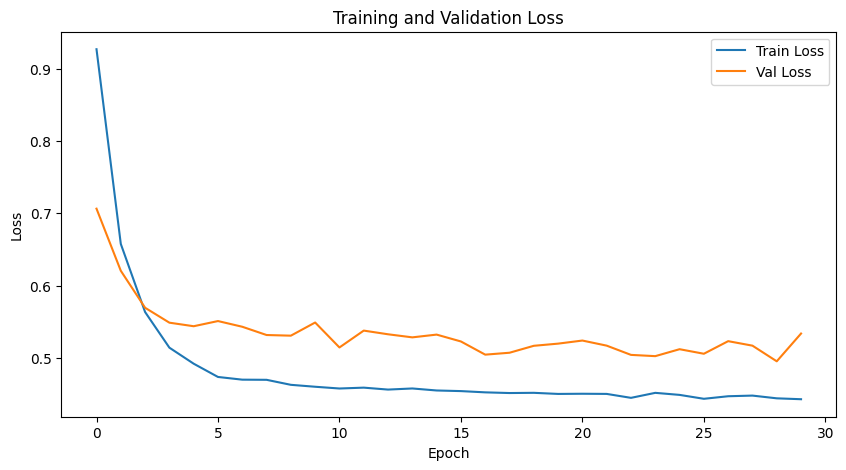

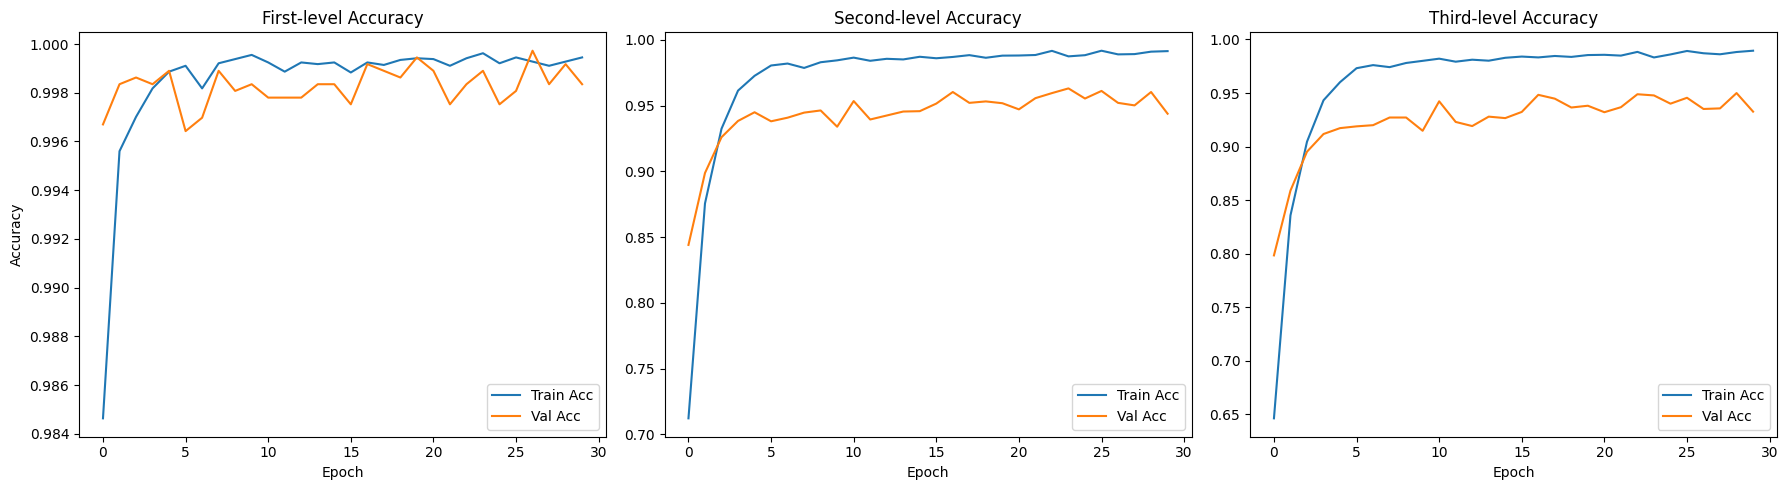

In [23]:
# Plot losses
plt.figure(figsize=(10, 5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Plot accuracies
fig, axes = plt.subplots(1, 3, figsize=(18,5))

axes[0].plot(history["train_acc_fst"], label="Train Acc")
axes[0].plot(history["val_acc_fst"], label="Val Acc")
axes[0].set_title("First-level Accuracy")
axes[0].set_xlabel("Epoch"); axes[0].set_ylabel("Accuracy"); axes[0].legend()

axes[1].plot(history["train_acc_sec"], label="Train Acc")
axes[1].plot(history["val_acc_sec"], label="Val Acc")
axes[1].set_title("Second-level Accuracy")
axes[1].set_xlabel("Epoch"); axes[1].legend()

axes[2].plot(history["train_acc_thr"], label="Train Acc")
axes[2].plot(history["val_acc_thr"], label="Val Acc")
axes[2].set_title("Third-level Accuracy")
axes[2].set_xlabel("Epoch"); axes[2].legend()

plt.tight_layout()
plt.show()

## Model Evaluation

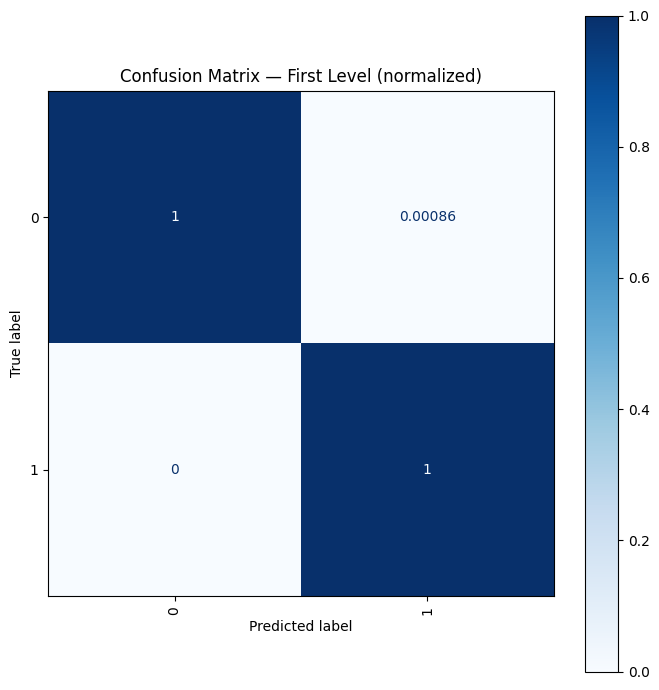

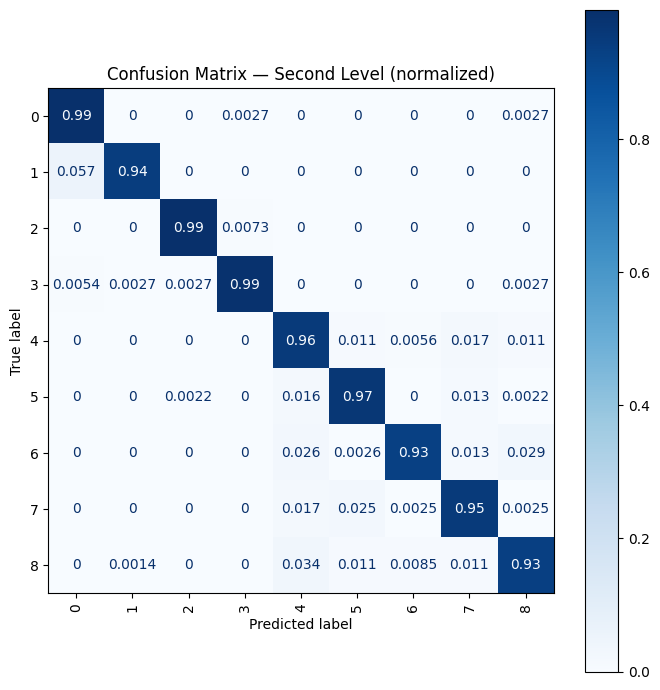

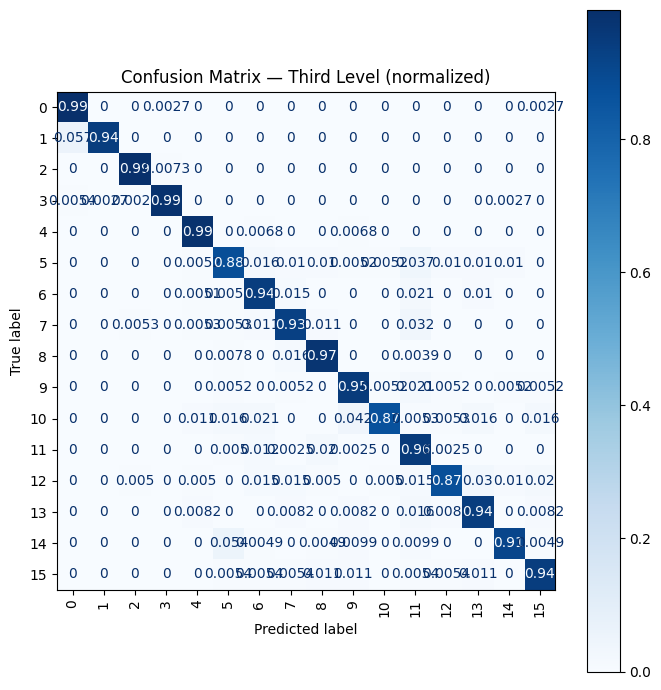

In [24]:


# Collect predictions and truths for each head
def collect_preds(model, loader, device):
  model.eval()
  fst_true, fst_pred = [], []
  sec_true, sec_pred = [], []
  thr_true, thr_pred = [], []

  with torch.no_grad():
    for xb, y1, y2, y3 in loader:
      xb = xb.to(device)
      with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
        o1, o2, o3 = model(xb)

        fst_true.extend(y1.numpy()); fst_pred.extend(o1.argmax(1).cpu().numpy())
        sec_true.extend(y2.numpy()); sec_pred.extend(o2.argmax(1).cpu().numpy())
        thr_true.extend(y3.numpy()); thr_pred.extend(o3.argmax(1).cpu().numpy())

  return (np.array(fst_true), np.array(fst_pred),
          np.array(sec_true), np.array(sec_pred),
          np.array(thr_true), np.array(thr_pred))

fst_t, fst_p, sec_t, sec_p, thr_t, thr_p = collect_preds(model, test_loader, device)

def plot_cm(y_true, y_pred, title, normalize=True, figsize=(7,7)):
  cm = confusion_matrix(y_true, y_pred, normalize="true" if normalize else None)
  fig, ax = plt.subplots(figsize=figsize)
  disp = ConfusionMatrixDisplay(cm)
  disp.plot(cmap="Blues", ax=ax, colorbar=True)
  ax.set_title(title + (" (normalized)" if normalize else ""))
  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

# Plot for each level
plot_cm(fst_t, fst_p, "Confusion Matrix — First Level", normalize=True)
plot_cm(sec_t, sec_p, "Confusion Matrix — Second Level", normalize=True)
plot_cm(thr_t, thr_p, "Confusion Matrix — Third Level", normalize=True)
